# Анализ оттока клиентов регионального банка

Задача: Провести анализ оттока клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов

# 1. Изучение общей информации и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('bank_dataset.csv')

In [3]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Приведем названия столбцов к нижнему регистру для удобства, а также переведем категориальные переменные в количественные, для дальнейшего анализа

In [5]:
# приводим названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()

# в столбце 'gender' изменим значения на числовые, а также выделим столбец с числовыми значениями городов

df['gender'] = df['gender'].map({'М':1, 'Ж':0})
df['city_int'] = df['city'].map({'Ярославль':0, 'Рыбинск':1, 'Ростов Великий':2})

# преобразуем датафрейм методом get_dummies(), чтобы разделить столбец 'city' на отдельные столбцы для каждого города

df = pd.get_dummies(df)

# 1.1 Проверка и заполнение пропущенных

In [6]:
print('Всего пропусков в столбце balance: {}'.format(df.isna().sum().sort_values(ascending=False)[0]))
print('Пропущено {}% значений в столбце balance'.format((df.isna().sum().sort_values(ascending=False)[0])*100/len(df)))

Всего пропусков в столбце balance: 3617
Пропущено 36.17% значений в столбце balance


Пропуски в столбце balance вызваны техническим сбоем при выгрузке. Посмотрим на распределение.

<ipython-input-7-aa04fbdddb9a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['balance'], hist=True, kde_kws={"shade": True}, bins=20, color="#26baee")
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


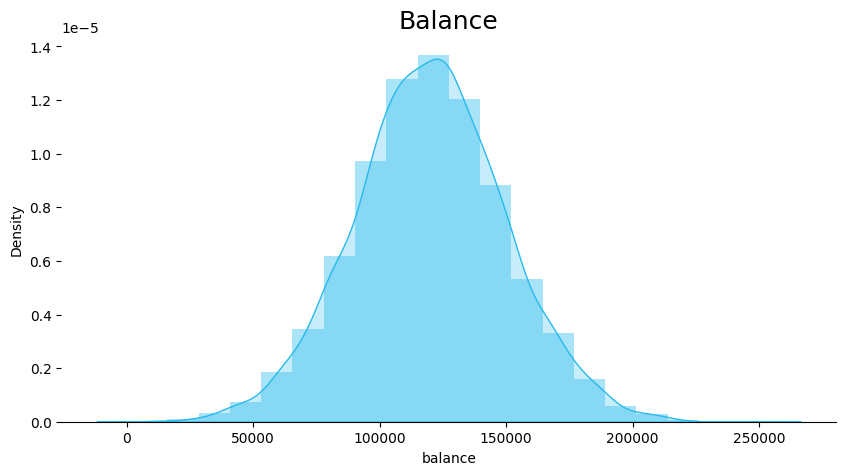

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Balance', fontsize=18)
sns.despine(left=True)
sns.distplot(df['balance'], hist=True, kde_kws={"shade": True}, bins=20, color="#26baee")

plt.show()

Данные распределены нормально, выбросов нет. Так как в дальнейшем мы будем проводить сегментацию пользователей по количесвту продуктов, посмотрим, как распределяются пропуски в балансе, относительно количества продуктов.

In [8]:
# Сохраним в переменных средние значения для столбцов, относительно количества продуктов

d = df.groupby('products')['balance'].mean().reset_index()
balance_1= d['balance'][0]
balance_2= d['balance'][1]
balance_3= d['balance'][2]
balance_4= d['balance'][3]

In [9]:
df['balance'] = df['balance'].fillna('0').astype('float')

a = df.query('balance == 0')
a.groupby('products')['userid'].count()

products
1     905
2    2600
3      98
4      14
Name: userid, dtype: int64

Так как больше половины значений столбца balance у пользователей с двумя продуктами пропущено, заполнение нулями исказит результаты. Можно заменить средними значениями, в зависимости от количества продуктов:

In [10]:
import numpy as np

df['balance'] = np.where((df['products'] == 1) & (df['balance'] == 0), #Identifies the case to apply to
                           balance_1,      #This is the value that is inserted
                           df['balance'])      #This is

df['balance'] = np.where((df['products'] == 2) & (df['balance'] == 0), #Identifies the case to apply to
                           balance_2,      #This is the value that is inserted
                           df['balance'])

df['balance'] = np.where((df['products'] == 3) & (df['balance'] == 0), #Identifies the case to apply to
                           balance_3,      #This is the value that is inserted
                           df['balance'])
df['balance'] = np.where((df['products'] == 4) & (df['balance'] == 0), #Identifies the case to apply to
                           balance_4,      #This is the value that is inserted
                           df['balance'])

df.balance.value_counts().head(4)

119660.944362    2600
119894.163723     905
119475.686310      98
122260.610870      14
Name: balance, dtype: int64

# 1.2 Проверка на наличие дублей

In [11]:
df.duplicated().value_counts()

False    10000
dtype: int64

Дублей нет, предобработка данных завершена.

## 2. Исследовательский анализ данных (EDA)

# 1.1 Изучим средние значения показателей

In [12]:
df.describe().round()

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_int,city_Ростов Великий,city_Рыбинск,city_Ярославль
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,15733677.0,651.0,1.0,39.0,5.0,119790.0,2.0,1.0,1.0,100090.0,0.0,1.0,0.0,0.0,1.0
std,71936.0,97.0,0.0,10.0,3.0,24044.0,1.0,0.0,0.0,57510.0,0.0,1.0,0.0,0.0,1.0
min,15608437.0,350.0,0.0,18.0,0.0,3769.0,1.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
25%,15671264.0,584.0,0.0,32.0,3.0,111581.0,1.0,0.0,0.0,51002.0,0.0,0.0,0.0,0.0,0.0
50%,15733474.0,652.0,1.0,37.0,5.0,119661.0,1.0,1.0,1.0,100194.0,0.0,0.0,0.0,0.0,1.0
75%,15795970.0,718.0,1.0,44.0,7.0,127644.0,2.0,1.0,1.0,149388.0,0.0,2.0,1.0,0.0,1.0
max,15858426.0,850.0,1.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0,2.0,1.0,1.0,1.0


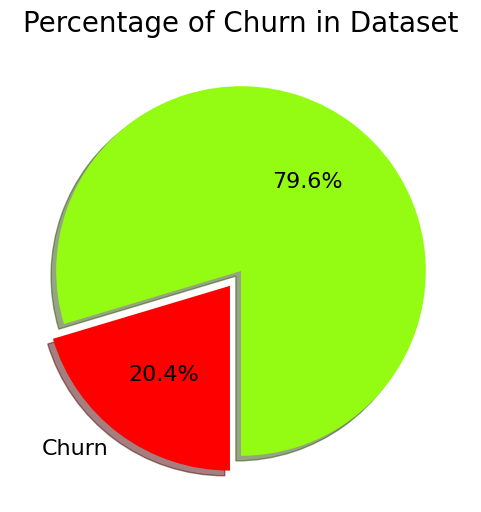

In [13]:
# Визуализируем процент оттока

from pylab import rcParams

# Data to plot
sizes = df['churn'].value_counts(sort = True)
colors = ["#94fc13","#ff0000"]
labels = '', 'Churn'
explode = (0, 0.1)
rcParams['figure.figsize'] = 6,6

# Plot
plt.pie(sizes, explode=explode, colors=colors, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=270, textprops={'fontsize': 16})

plt.title('Percentage of Churn in Dataset', fontdict = {'fontsize' : 20})
plt.show()

Ушло 20% клиентов по данным за месяц. Это много, посмотрим подробнее на признаки.

# Средние значения относительно оттока.

Построим распределение признаков у тех, кто ушел и тех, кто остался.

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

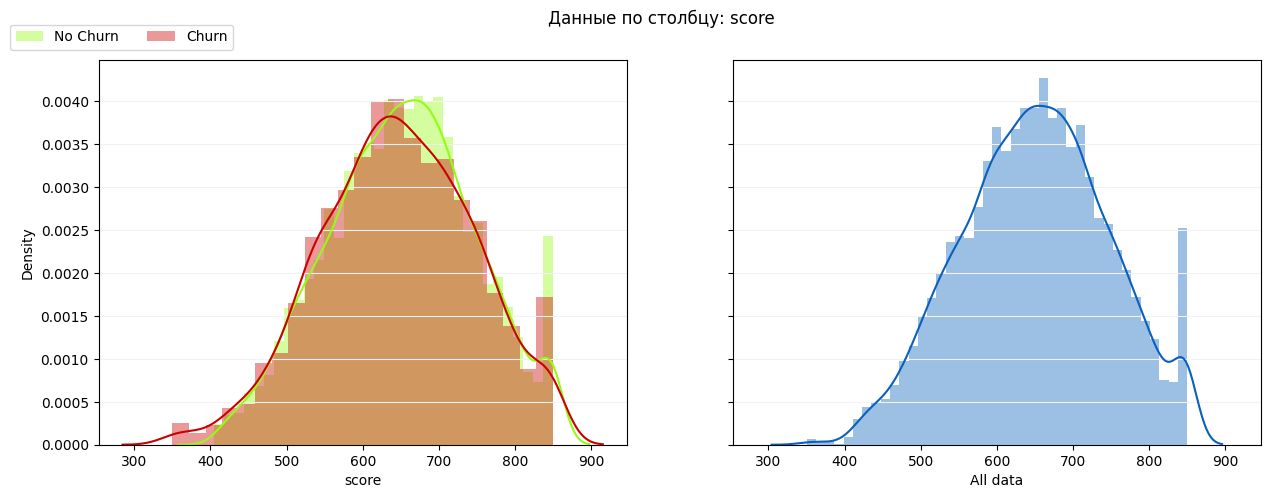

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

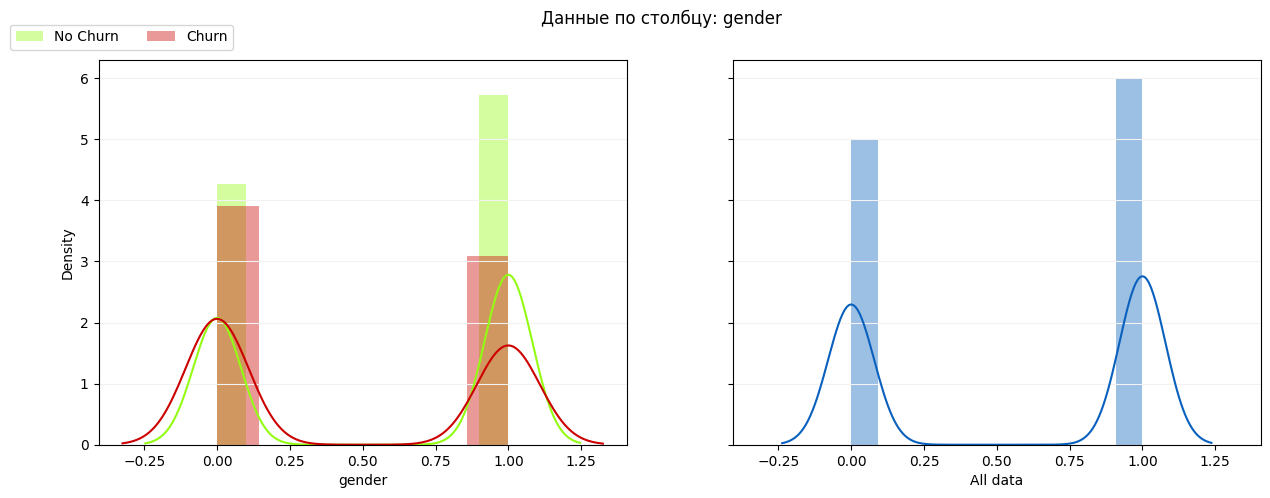

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

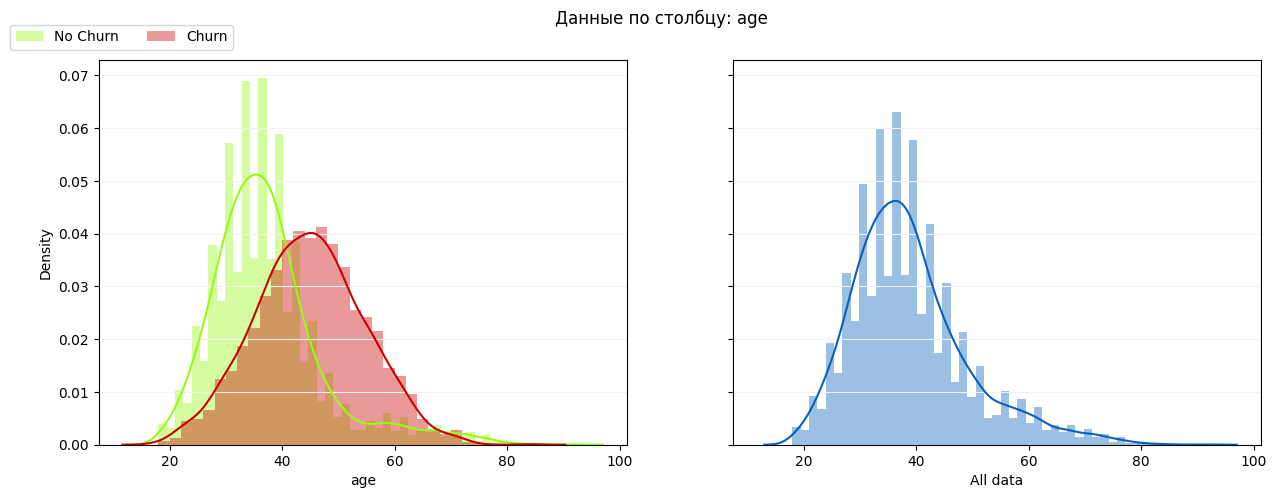

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

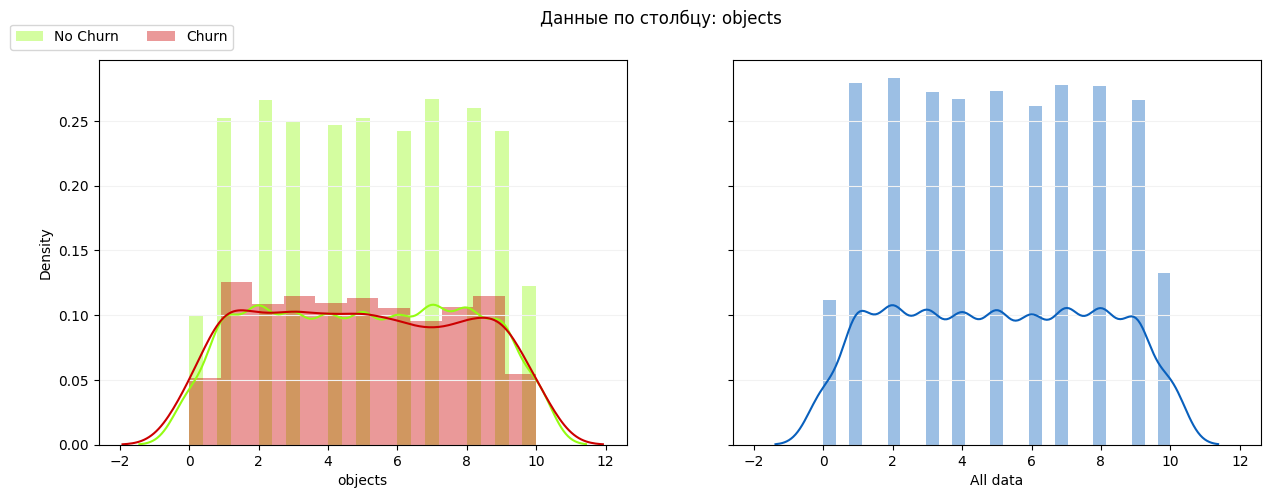

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

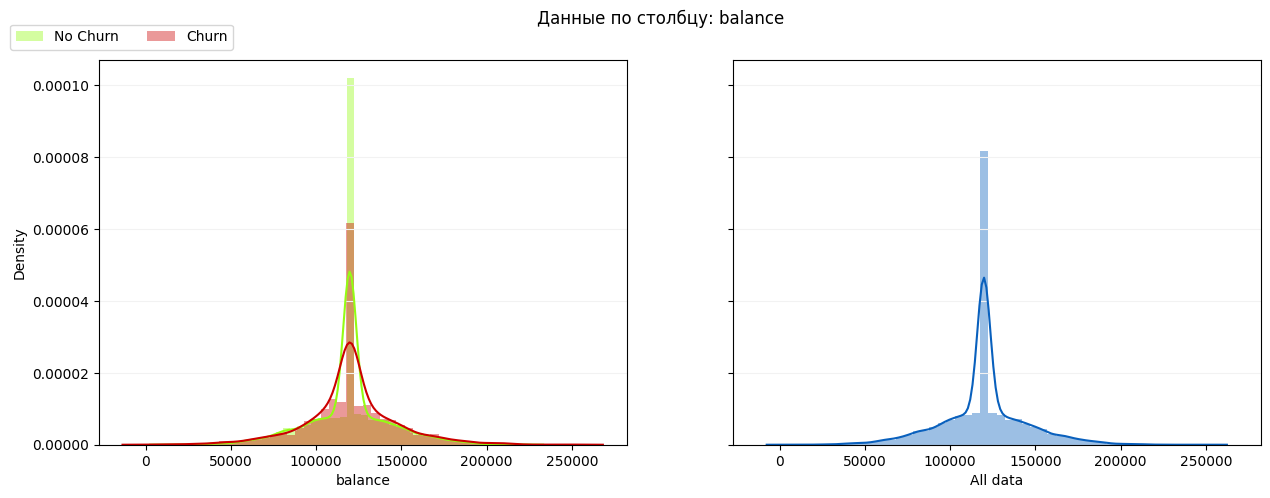

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

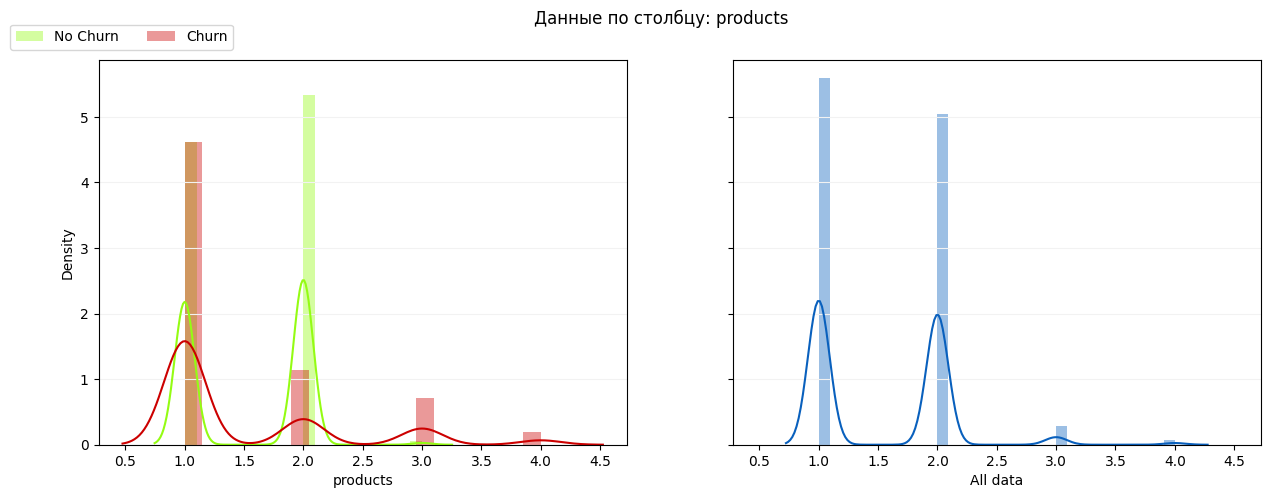

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

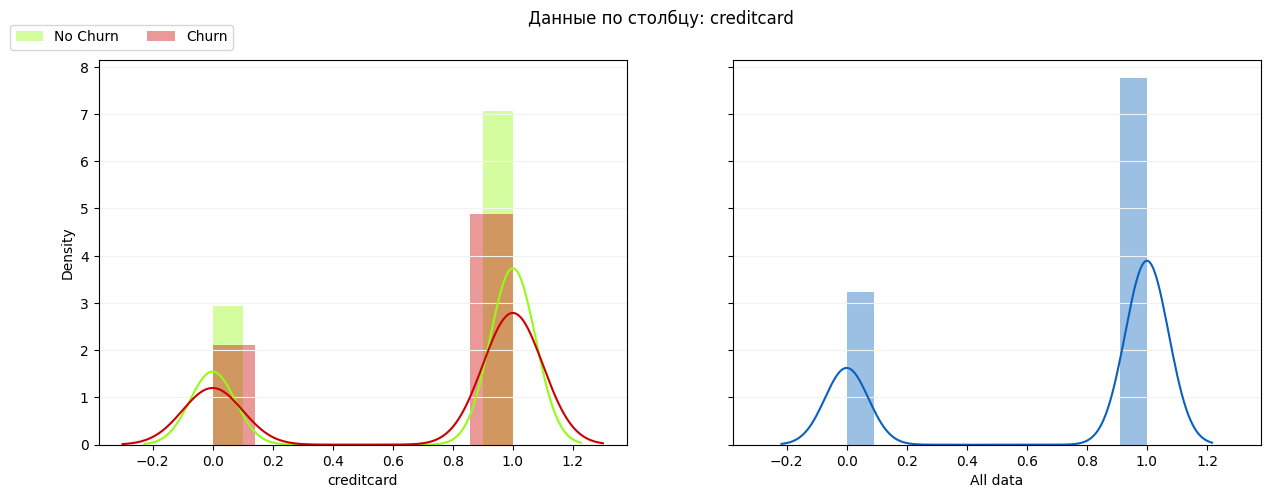

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

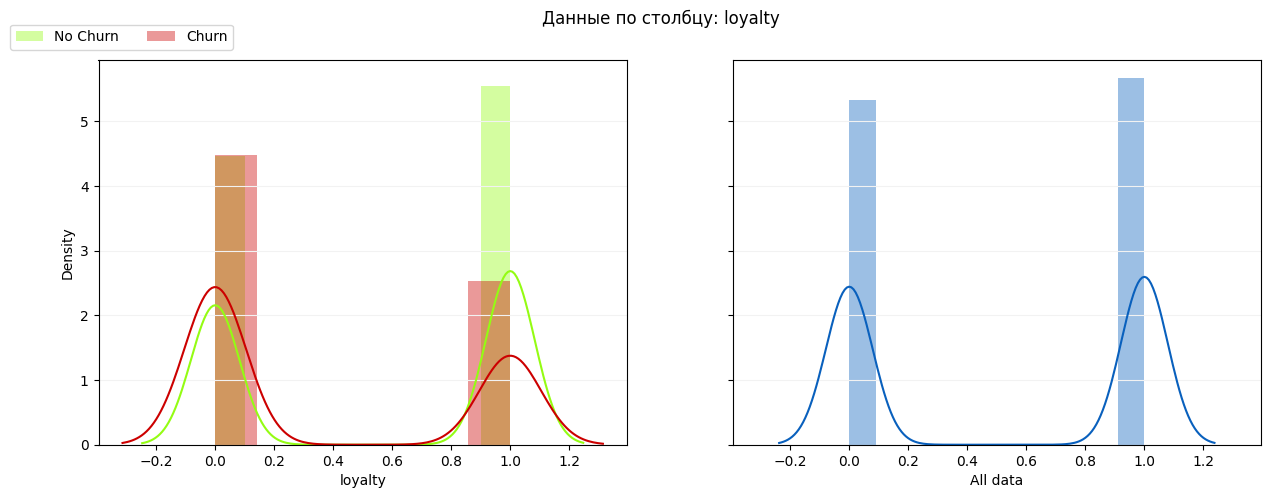

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

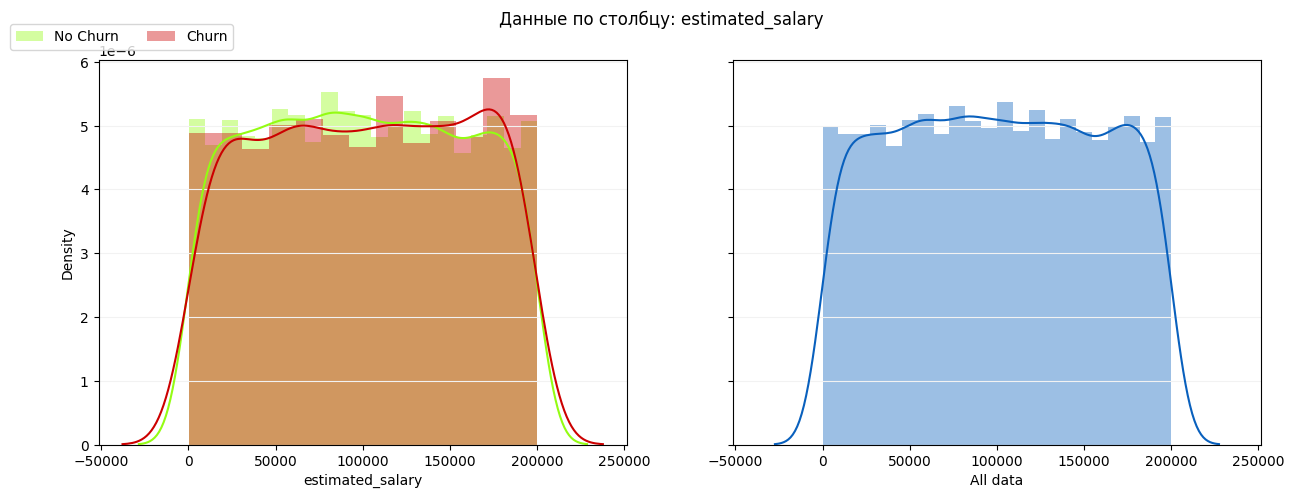

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

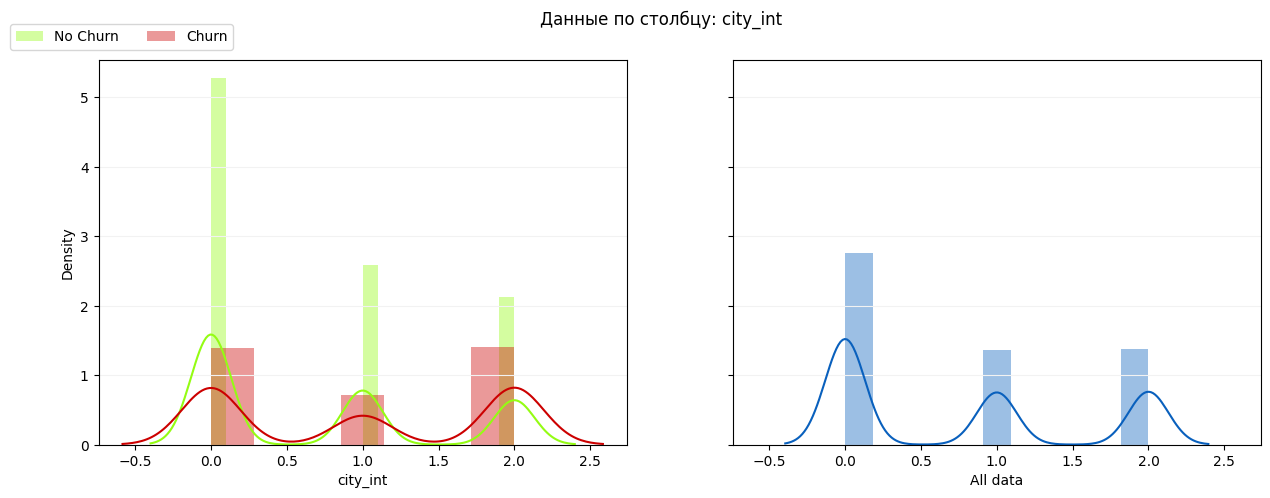

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

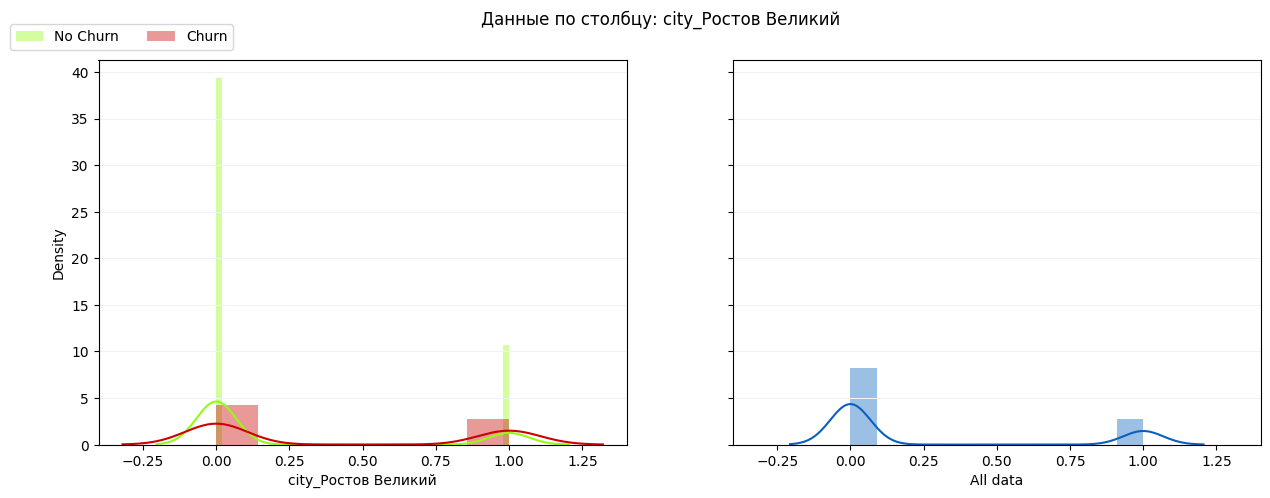

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

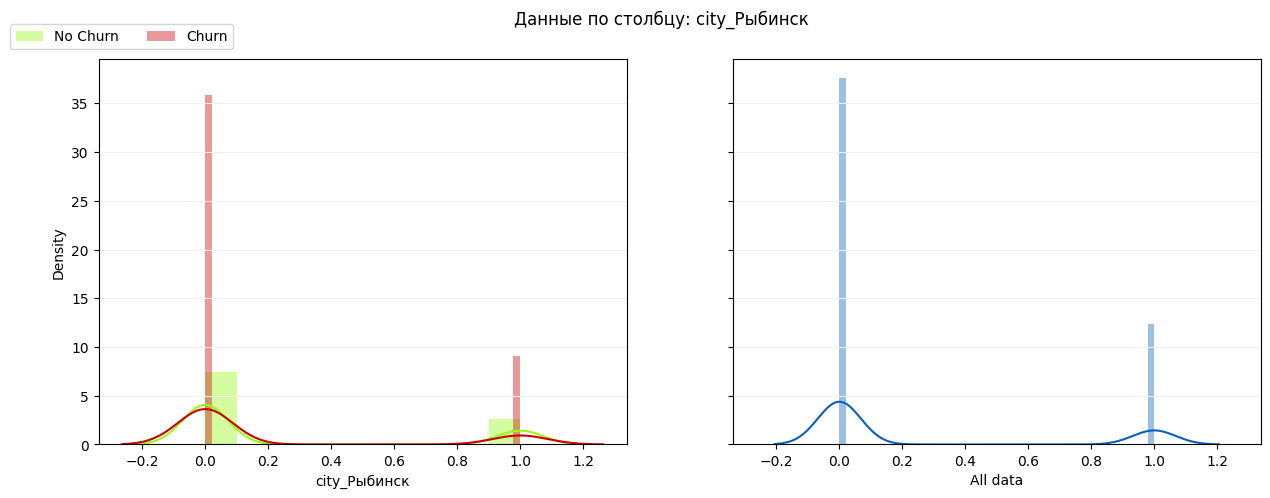

<ipython-input-15-f48544e35492>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
<ipython-input-15-f48544e35492>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
<ipython-input-15-f48544e35492

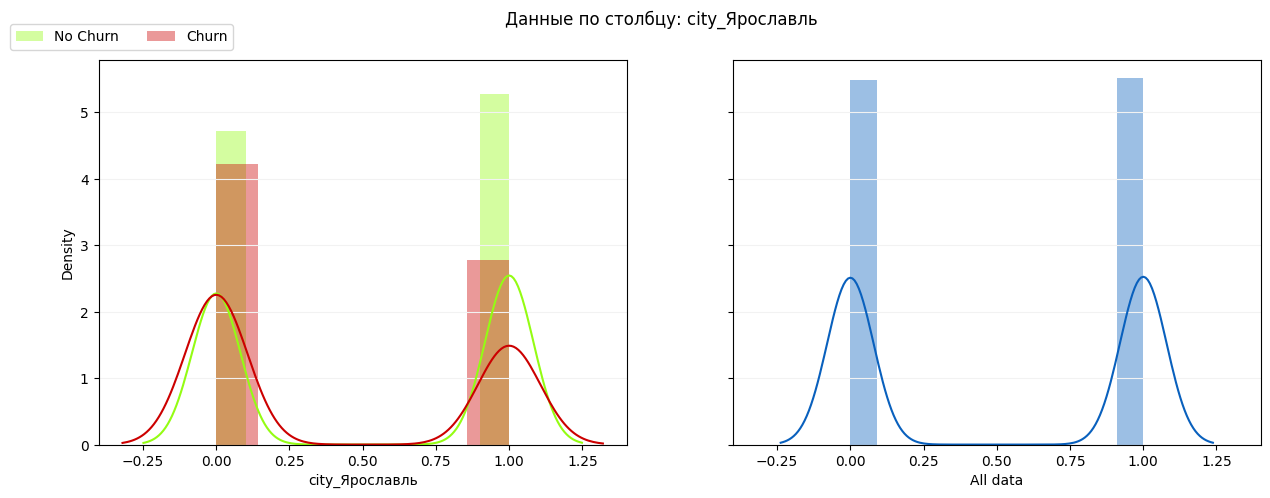

In [15]:
columns = df.drop(['churn', 'userid'], axis=1).columns
for col in columns:
    x1 = df[df['churn']==0][col]
    x2 = df[df['churn']==1][col]
    x3 = df[col]
# plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle('Данные по столбцу: ' + col)
    sns.distplot(x1 , color="#94fc13", ax=axes[0], label='No Churn')
    sns.distplot(x2 , color="#cc0000", ax=axes[0], label = 'Churn')
    sns.distplot(x3 , color="#0960bd", ax=axes[1], axlabel='All data')
    fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
    axes[0].set(ylabel='Density')
    axes[0].grid(axis='y', color='0.95')
    axes[1].grid(axis='y', color='0.95')
    plt.show()

По графикам можно заметить, что к оттоку более склонны женщины, не лояльные клиенты - те, кто не пользовался продуктами/приложением за последний месяц, также на отток влияет возраст - уходят более возрастные клиенты.

## 2.2 Матрица корреляций

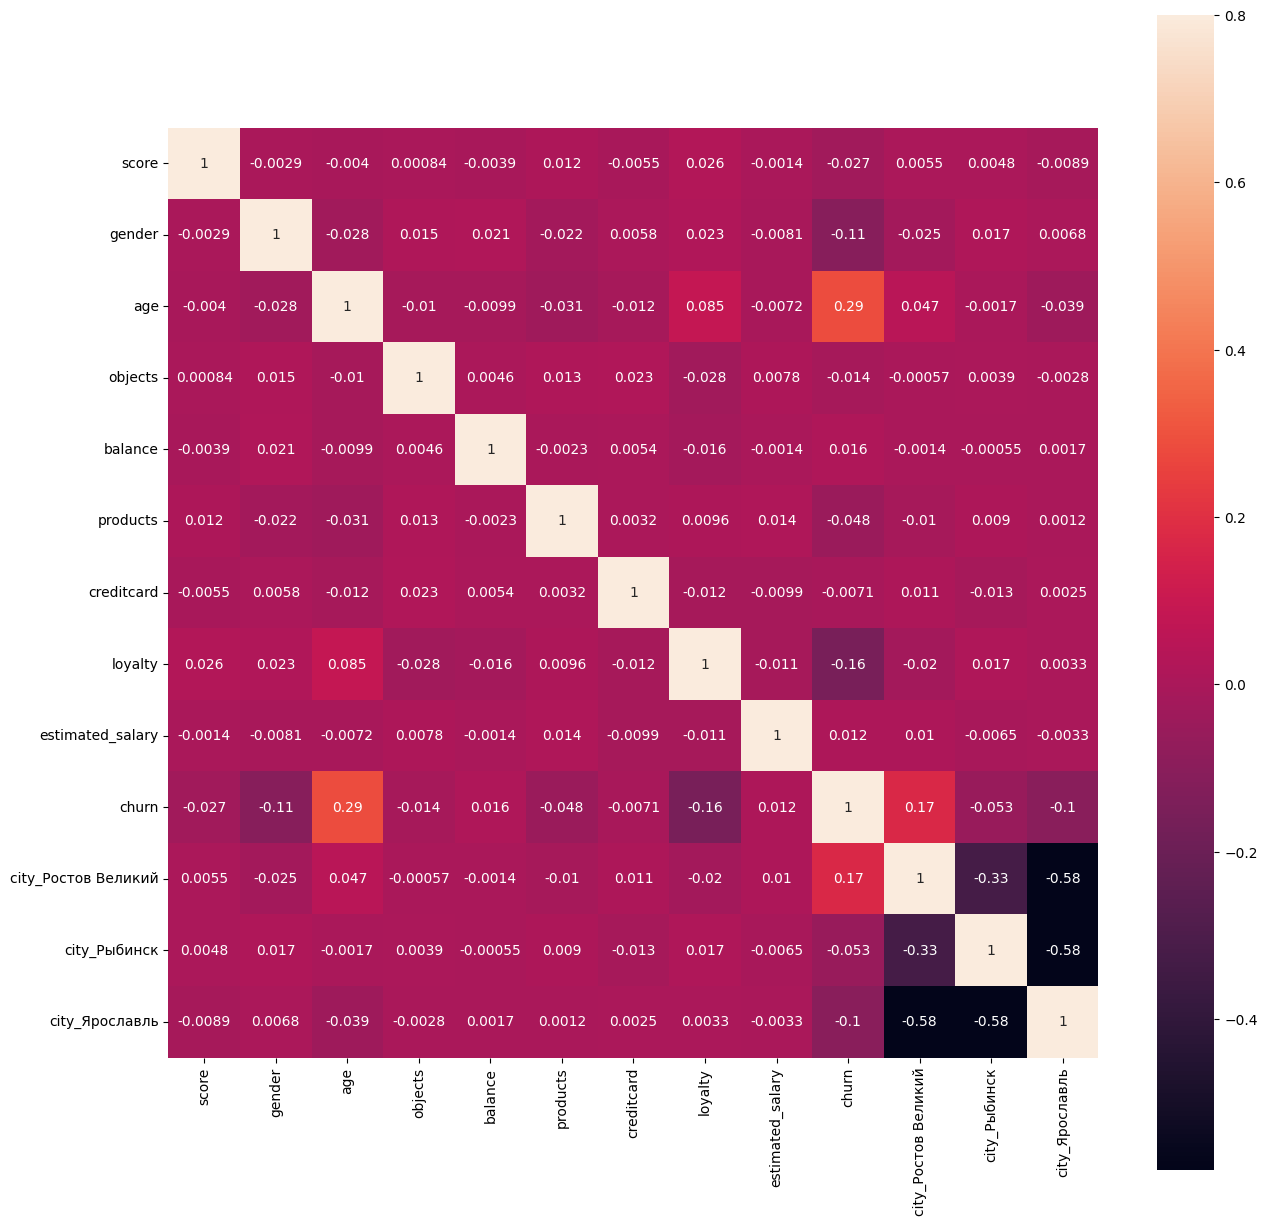

In [16]:
corr_m = df.drop(['userid', 'city_int'], axis=1).corr()
corr_m
# отобразим heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square=True, vmax=0.8, annot = True)

plt.show()

Мультиколлинеарности не обнаружено, все признаки незначительно коррелируют друг с другом. С целевой переменной churn больше всего коррелирует age, city_Ростов Великий, loyalty и gender.

In [17]:
city_churn = df.groupby('churn')['city_int'].value_counts().reset_index(level='churn')
city_churn.columns = ('churn', 'number')
city_churn = city_churn.sort_values(by='city_int')
city_total = city_churn.pivot_table(index='city_int', values='number', aggfunc='sum')

In [18]:
import plotly.graph_objs as go

labels = ['Ярославль','Рыбинск','Ростов Великий']
labels1 = ['No Churn', 'Churn', ' ', '  ', '   ', '    ']
outer_values = [city_total['number'][0], city_total['number'][1], city_total['number'][2]]
inner_values = city_churn['number']

#common_props = dict(labels=labels,
#                    values=outer_values)

trace1 = go.Pie(
    hole=0.3,
    sort=False,
    direction='clockwise',
    domain={'x': [0.15, 0.85], 'y': [0.15, 0.85]},
    values=inner_values,
    showlegend= False,
    labels=labels1,
    textinfo='label',
    textposition='inside',
    marker={'colors': ['#94fc13', '#ff0000', '#94fc13', '#ff0000','#94fc13', '#ff0000'],
            'line': {'color': 'white', 'width': 1}}
)

trace2 = go.Pie(
    hole=0.7,
    sort=False,
    direction='clockwise',
    values=outer_values,
    labels=labels,
    textinfo='percent',
    textposition='inside',
    marker={'colors': ['#82acff', '#8f71ff', '#866ec7'],
            'line': {'color': 'white', 'width': 2}}
)

layout = go.Layout(height = 600,
                   width = 600,
                   autosize = True,
                   title = 'Churn By City',
                   title_font_size=30,
                   title_x=0.4)
fig = go.FigureWidget(data=[trace1, trace2], layout=layout)

fig.show()

## 3. Модель для предсказания оттока клиентов и кластеризация.

# 3.1 Выбор и обучение модели для предсказания оттока

Обучим модели для прогнозирования оттока клиентов четырьмя способами. Выберем оптимальный по метрикам Accuracy, Precision, Recall, F1, ROC_AUC

In [19]:
df1 = df.drop(['city_int', 'userid'], axis=1)
df1['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn', 'city_int', 'userid'], axis = 1)
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')


# Модель на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(random_state = 0)

tree_model.fit(X_train_st, y_train)
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, tree_predictions, tree_probabilities, title='Метрики для модели дерева решений:')


# Модель на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')


# сделаем все то же самое для алгоритма градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 0)

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test_st)
gb_probabilities = gb_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, gb_predictions, gb_probabilities, title = 'Метрики для модели градиентного бустинга:')

Метрики для модели логистической регрессии:
	Accuracy: 0.82
	Precision: 0.62
	Recall: 0.23
	F1: 0.34
	ROC_AUC: 0.77
Метрики для модели дерева решений:
	Accuracy: 0.81
	Precision: 0.52
	Recall: 0.56
	F1: 0.54
	ROC_AUC: 0.72
Метрики для модели случайного леса:
	Accuracy: 0.86
	Precision: 0.74
	Recall: 0.51
	F1: 0.60
	ROC_AUC: 0.86
Метрики для модели градиентного бустинга:
	Accuracy: 0.20
	Precision: 0.20
	Recall: 1.00
	F1: 0.34
	ROC_AUC: 0.66


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Random Forest выглядит наиболее адекватной и точной моделью. Посмотрим важность признаков:

In [21]:
importances = pd.DataFrame({'feature': X.columns, 'importance':rf_model.feature_importances_})
importances.sort_values(by='importance', ascending=False)

,feature,importance
2,age,0.232962
4,balance,0.167791
8,estimated_salary,0.143909
0,score,0.140983
5,products,0.113057
3,objects,0.080191
7,loyalty,0.038124
9,city_Ростов Великий,0.023748
1,gender,0.019862
6,creditcard,0.018350


Самый важный признак для модели - age. Модель можно использовать, например, для сравнения прогнозного значения продкутов и фактического. Тем, у кого прогнозное больше, можно предложить новый продукт. С помощью модели также можно предотвратить отток тех, кому она предсказывает уход, но клиент еще не успел.

## 3.2 Кластеризация клиентов

С помощью построения дендрограммы определим рекомендуемое число кластеров

In [23]:
from sklearn.cluster import KMeans

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop(['churn', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль'], axis = 1))

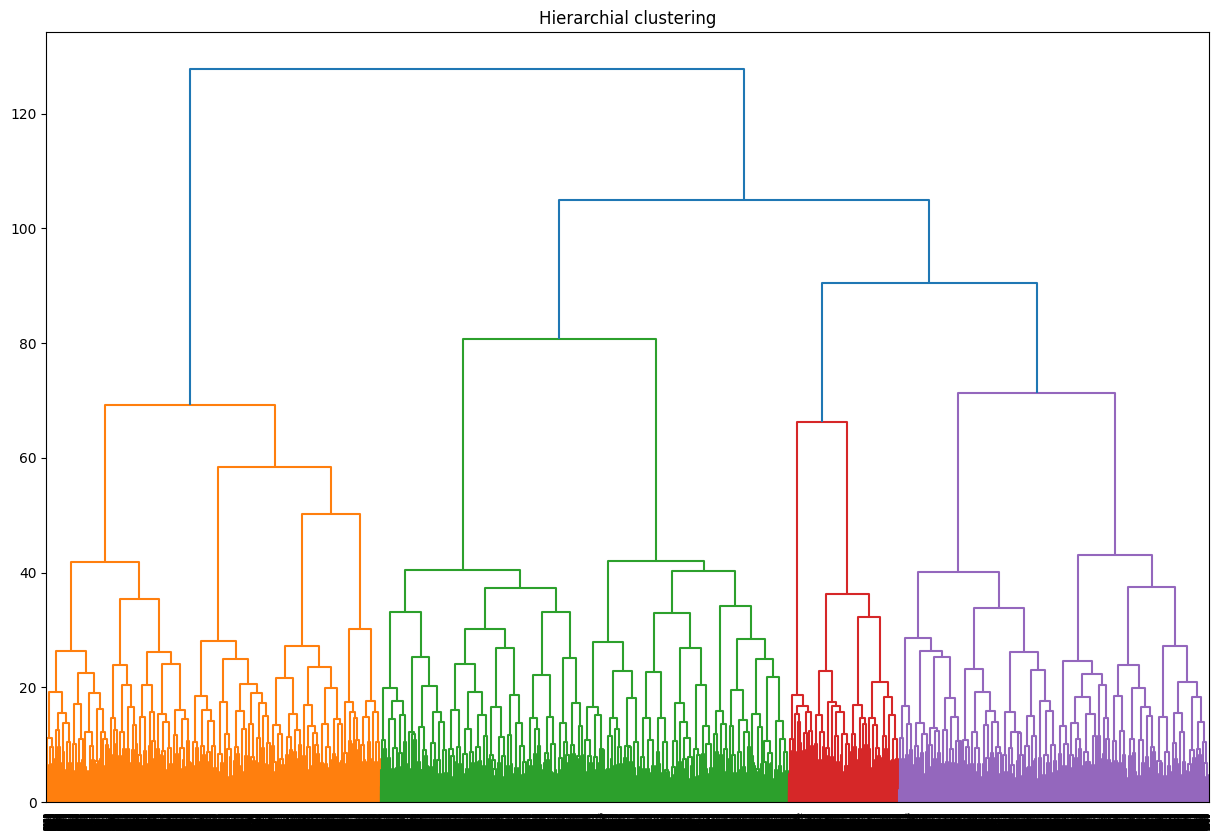

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Построим матрицу расстояний функцией linkage()
linked = linkage(x_sc, method = 'ward')

# Нарисуйте дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

**Рекомендуемое число кластеров - 4**

In [25]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
mean_features = df.groupby('cluster_km').mean().reset_index()
#display(grouped_features)

grouped_features = pd.pivot_table(df, index='cluster_km',
                    aggfunc={'userid': 'nunique',
                             'score': np.median,
                             'products': np.mean,
                             'gender': np.mean,
                             'age': np.median,
                             'objects': np.mean,
                             'balance': np.mean,
                             'creditcard': np.mean,
                             'loyalty': np.mean,
                             'estimated_salary': np.mean,
                             'churn': np.mean,
                             #'city_Ростов Великий': np.mean,
                             #'city_Рыбинск': np.mean,
                             #'city_Ярославль': np.mean
                             })
grouped_features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,age,balance,churn,creditcard,estimated_salary,gender,loyalty,objects,products,score,userid
cluster_km,,,,,,,,,,,
0,38,119383.364420,0.249060,1,99866.690188,0.000000,0.497180,4.990602,1.543860,651,3192
1,38,119590.650697,0.208149,0,100974.397711,0.541256,0.524278,4.911715,1.527334,654,2945
2,37,119480.702360,0.103960,1,98914.378703,1.000000,1.000000,5.046040,1.534158,655,2020
3,37,121152.820347,0.227347,1,100353.378996,1.000000,0.000000,5.176343,1.506782,648,1843


In [26]:
# Визуализируем, как пользователи распределяются по кластерам

labels = 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'
values = grouped_features['userid']

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo='label', hole=.3)])
fig.show()

In [ ]:
print(' Средний показатель оттока по всему датафрейму: {}%'.format(((df['churn'].mean())*100).round(1)))

Средний показатель оттока по всему датафрейму: 20.4%

Некоторые показатели во всех кластерах примерно одинаковы: age, balance, estimated_salary, objects, products, score Разделение на кластеры произошло по параметрам: creditcard, gender, loyalty.

> **Cluster 0** - женщины, пользующихся кредитными картами, средняя лояльность - самый высокий показатель оттока (25%)

> **Cluster 1** - женщины и мужчины в примерно равном соотношении, без кредитной карты, средняя лояльность, отток (21%)

> **Cluster 2** - мужчины, с кредитными картами, активно пользующиеся продуктами/приложением - наименьший показатель оттока (10%)

> **Cluster 3** - мужчины, с кредитными картами, не пользующиеся продуктами/приложением, отток (23%)


**Визуализируем разницу между кластерами**

In [27]:
mean_features = (mean_features
                    .drop(['userid', 'age','estimated_salary', 'balance', 'objects','score', 'products', 'city_int',
                           'city_Ярославль', 'city_Рыбинск', 'city_Ростов Великий'], axis=1))

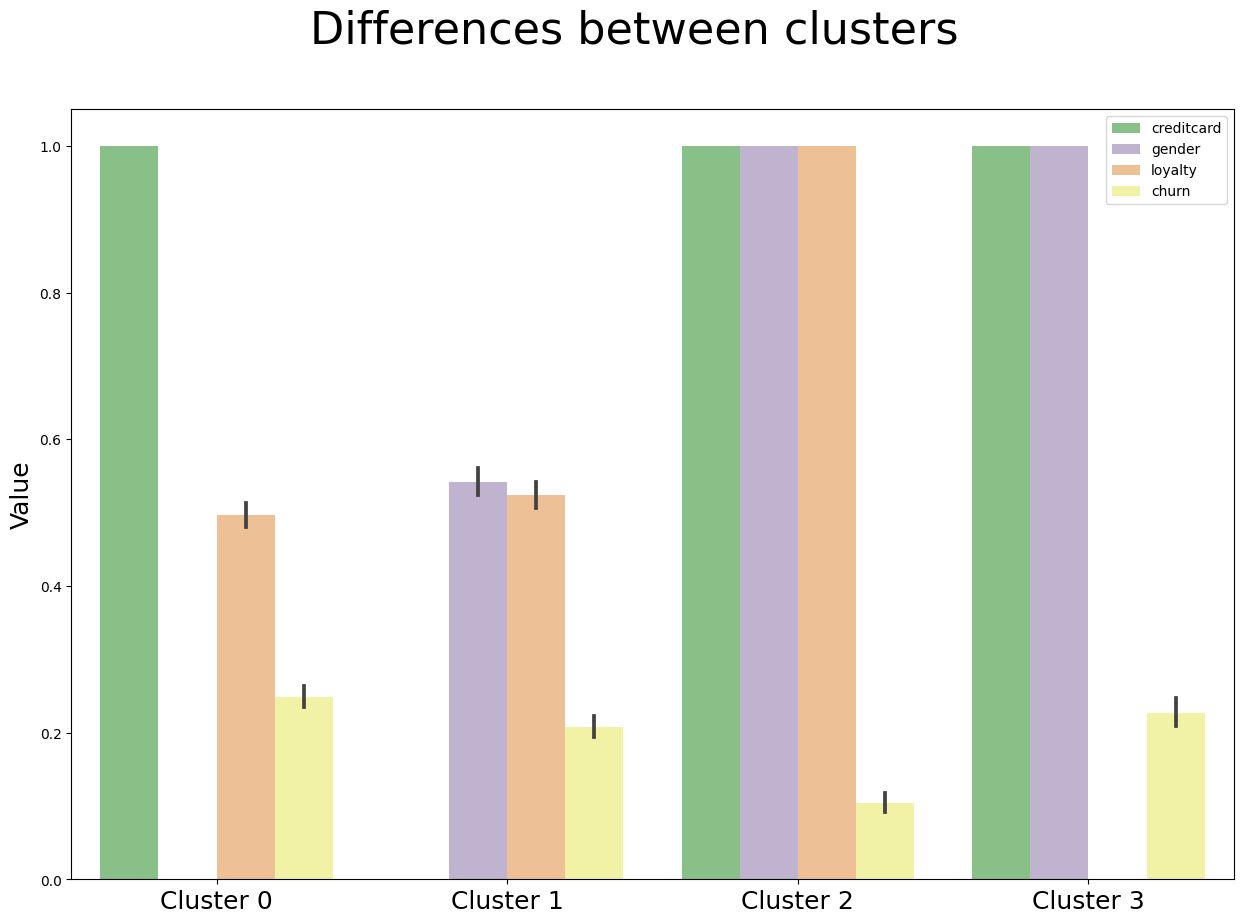

In [28]:
results = pd.DataFrame(columns=['Variable', 'Var'])
for column in mean_features.columns[1:]:
    results.loc[len(results), :] = [column, np.var(mean_features[column])]
selected_columns = list(results.sort_values(
        'Var', ascending=False,
    ).head(7).Variable.values) + ['cluster_km']
tidy = df[selected_columns].melt(id_vars='cluster_km')

fig = plt.figure(figsize=(15, 10))
sns.barplot(x='cluster_km', y='value', hue='variable', data=tidy, palette="Accent")
#plt.suptitle("Simple Plot", fontsize=12)
fig.suptitle('Differences between clusters', fontsize=32)
plt.xlabel('')
plt.ylabel('Value', fontsize=18)
plt.xticks(np.arange(4), ['Cluster 0', 'Cluster 1','Cluster 2', 'Cluster 3'], fontsize=18)
plt.legend()

plt.show()

В Cluster 2 и Cluster 3 собраны мужчины, с примерно одинаковыми параметрами, но разными показателями loyalty. В Cluster 2 с лояльными клиентами отток в два раза ниже, чем в Cluster 3 где loyalty равен нулю. Также, есть предположение, что женщины склонны к оттоку больше, чем мужчины.

## 4. Сегментация пользователей


Сегментируем пользователей на основе данных о количестве продуктов

In [ ]:
import numpy as np
pd.pivot_table(df, index='products',
                    aggfunc={'age': np.median,
                             'balance': np.mean,
                             'churn': np.mean,
                             'city_Ростов Великий': np.mean,
                             'city_Рыбинск': np.mean,
                             'city_Ярославль': np.mean,
                             'creditcard': np.mean,
                             'estimated_salary': np.median,
                             'gender': np.mean,
                             'loyalty': np.mean,
                             'objects': np.mean,
                             'score': np.median,
                             'userid': 'nunique'
                             })

Так как группы с тремя и четырьмя продуктами малочисленны, разделим клиентов на три сегмента. Можно заметить, что в сегмент с 3-4 продуктами попала более возрастная категория клиентов, преимущественно женского пола.

In [29]:
# Добавим в датафрейм столбец с сегментами

df['segments'] = df['products'].replace(4, 3)
df['segments'].value_counts().reset_index()

,index,segments
0,1,5084
1,2,4590
2,3,326


In [30]:
segments = df.pivot_table(index='segments').reset_index()

In [31]:
segments

,segments,age,balance,churn,city_int,city_Ростов Великий,city_Рыбинск,city_Ярославль,cluster_km,creditcard,estimated_salary,gender,loyalty,objects,products,score,userid
0,1,39.673092,119894.163723,0.277144,0.770850,0.265342,0.240165,0.494493,1.259441,0.703777,99487.256851,0.548387,0.504131,4.974626,1.000000,649.120968,1.573237e+07
1,2,37.753595,119660.944362,0.075817,0.710893,0.226580,0.257734,0.515686,1.255556,0.707190,100452.012821,0.551198,0.532898,5.051852,2.000000,652.188671,1.573484e+07
2,3,43.653374,119988.249112,0.858896,0.960123,0.368098,0.223926,0.407975,1.067485,0.708589,104400.141503,0.426380,0.435583,5.058282,3.184049,649.113497,1.573768e+07


<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

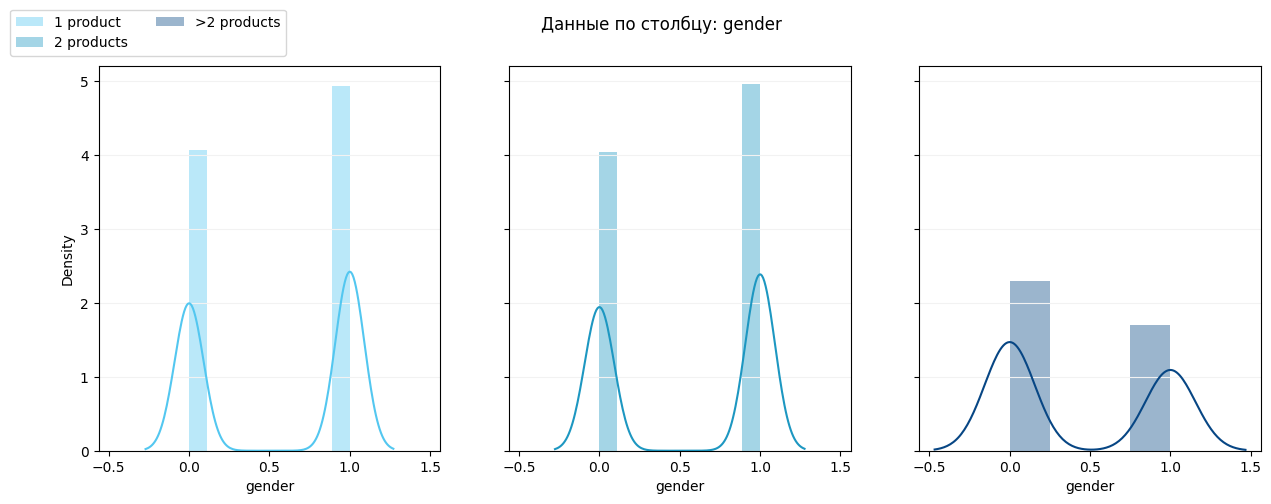

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

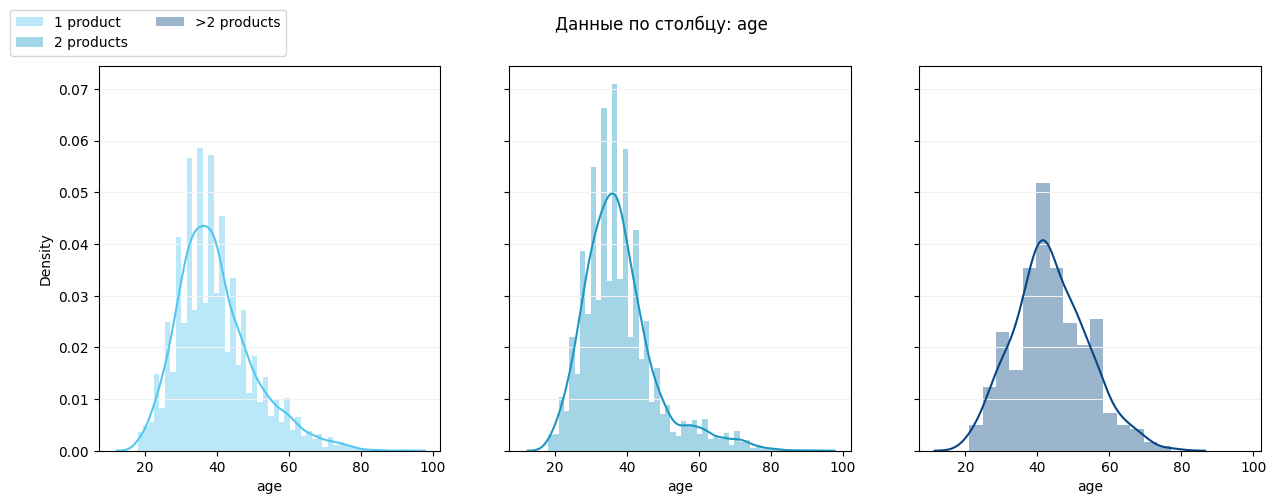

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

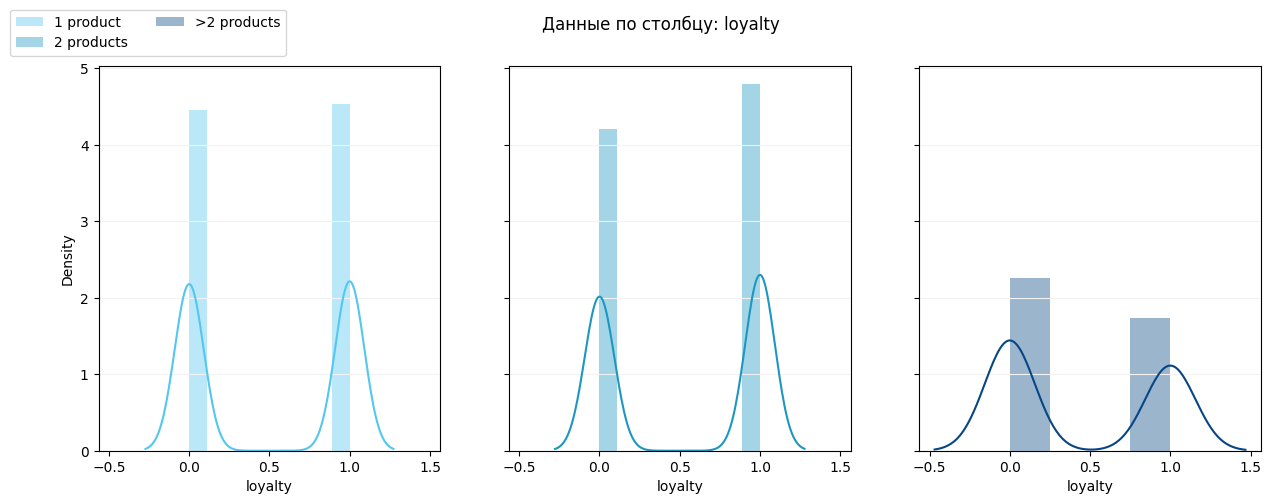

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

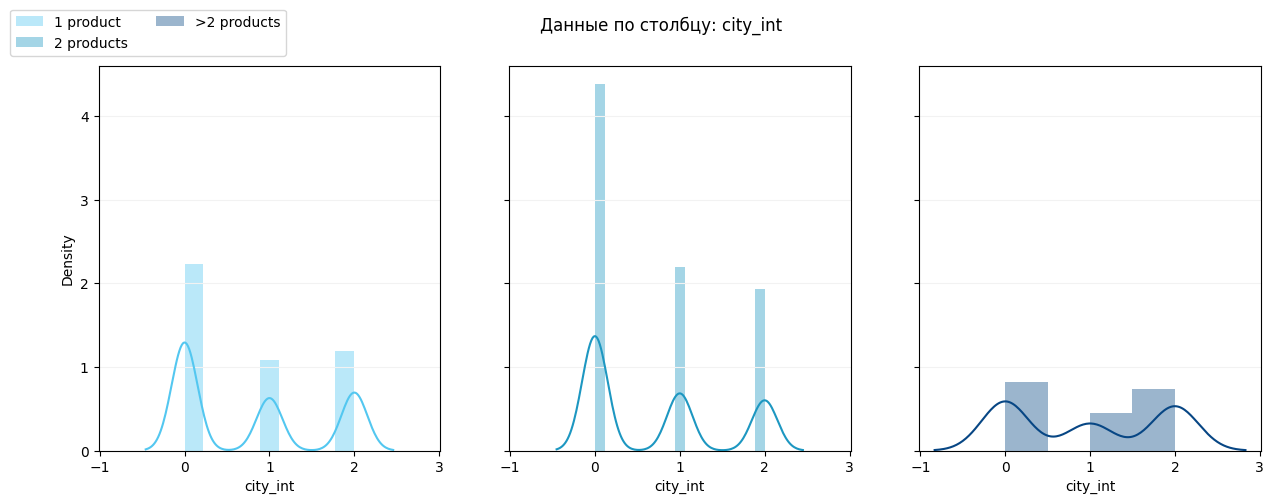

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

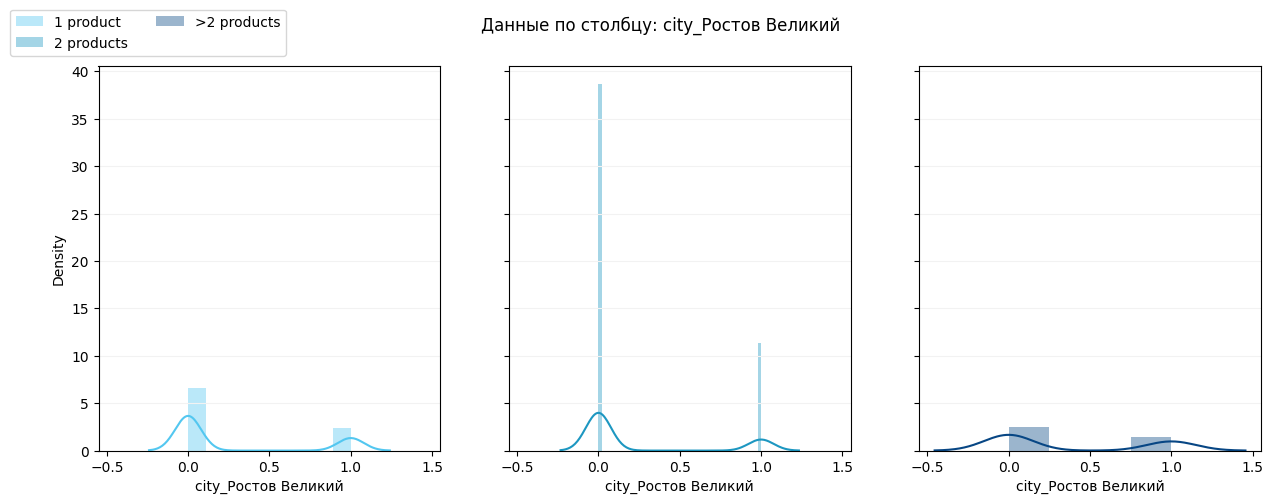

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

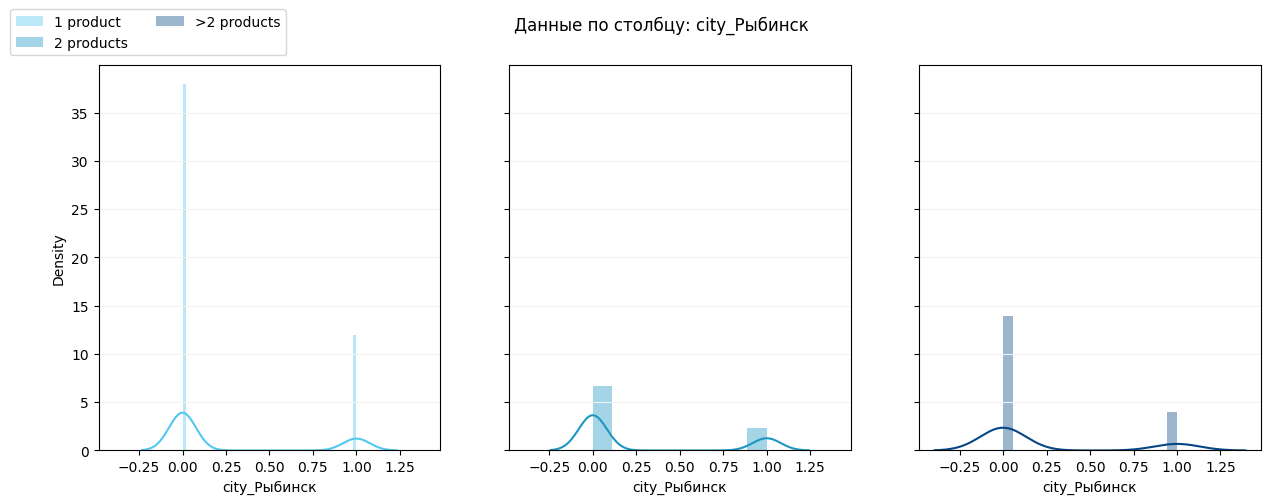

<ipython-input-32-4ab7d9c7f07a>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-32-4ab7d9c7f07a>:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

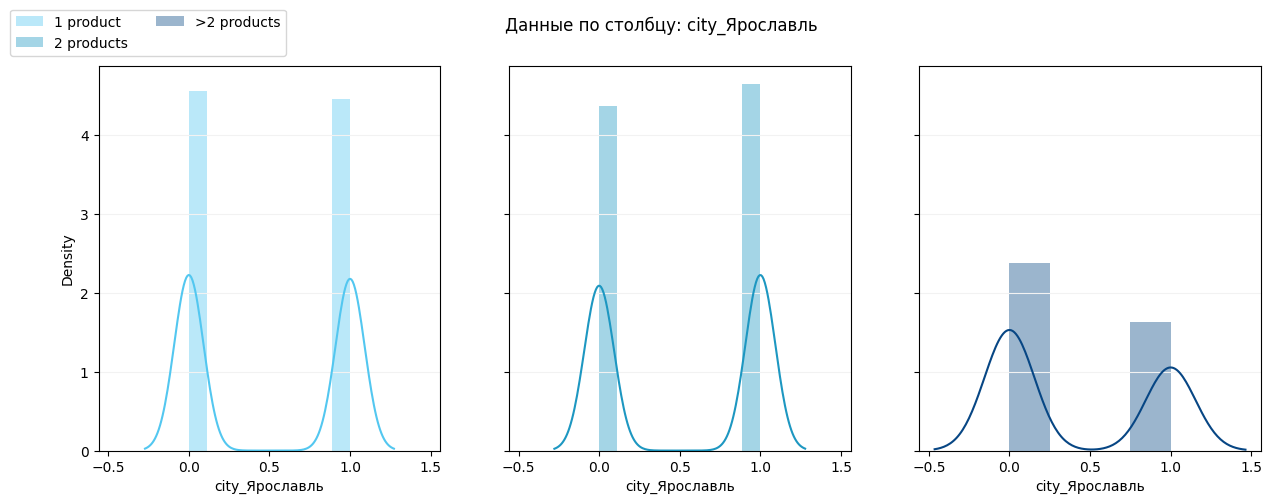

In [32]:
# Значения столбца 'city_int' - 'Ярославль':0, 'Рыбинск':1, 'Ростов Великий':2

for col in df.drop(['segments', 'userid', 'balance', 'cluster_km',
                    'creditcard', 'estimated_salary', 'objects', 'score', 'products', 'churn'], axis=1).columns:
    x1 = df.query('segments == 1')[col]
    x2 = df.query('segments == 2')[col]
    x3 = df.query('segments == 3')[col]
#plot '#87e0ff', '#53c7f0', '#1d97c1'
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle('Данные по столбцу: ' + col)
    sns.distplot(x1 , color='#53c7f0', ax=axes[0], label='1 product')
    sns.distplot(x2 , color='#1d97c1', ax=axes[1], label = '2 products')
    sns.distplot(x3 , color='#074684', ax=axes[2], label = '>2 products')
    fig.legend(bbox_to_anchor=(0.066, 0.9), loc='lower left', ncol=2, borderaxespad=0.)
    axes[0].set(ylabel='Density')
    for ax in (axes[0], axes[1],axes[2]):
        ax.grid(axis='y', color='0.95')
    plt.show()

In [33]:
s = pd.pivot_table(df, index='segments',
                    aggfunc={'churn': 'mean',
                             'userid': 'nunique'
                             }).reset_index()

s['churn'] = (s['churn'] * 100).round()
s

,segments,churn,userid
0,1,28.0,5084
1,2,8.0,4590
2,3,86.0,326


In [34]:
# Посмотрим на отток по сегментам

data = df.groupby(['segments', 'churn']).size().rename('count').reset_index()
data

,segments,churn,count
0,1,0,3675
1,1,1,1409
2,2,0,4242
3,2,1,348
4,3,0,46
5,3,1,280


In [35]:
import plotly.graph_objs as go

labels = ['1 product','2 products','>2 products']
labels1 = ['No Churn', 'Churn', ' ', '  ', '   ', '    ']
outer_values = [data['count'][0]+data['count'][1], data['count'][2]+data['count'][3], data['count'][4]+data['count'][5]]
inner_values = data['count']

#common_props = dict(labels=labels,
#                    values=values,)

trace1 = go.Pie(
    hole=0.3,
    sort=False,
    direction='clockwise',
    domain={'x': [0.15, 0.85], 'y': [0.15, 0.85]},
    values=inner_values,
    showlegend= False,
    labels=labels1,
    textinfo='label',
    textposition='inside',
    marker={'colors': ['#94fc13', '#ff0000', '#94fc13', '#ff0000','#94fc13', '#ff0000'],
            'line': {'color': 'white', 'width': 1}}
)

trace2 = go.Pie(
    hole=0.7,
    sort=False,
    direction='clockwise',
    values=outer_values,
    labels=labels,
    textinfo='percent',
    textposition='inside',
    marker={'colors': ['#87e0ff', '#53c7f0', '#1d97c1'],
            'line': {'color': 'white', 'width': 2}}
)

layout = go.Layout(height = 600,
                   width = 600,
                   autosize = True,
                   title = 'Churn by segment',
                   title_font_size=30,
                   title_x=0.4)
fig = go.FigureWidget(data=[trace1, trace2], layout=layout)

fig.show()

Наибольший показатель оттока в третей группе (практически все клиенты уходят). Возможно, большое количество продуктов негативно сказывается на лояльности и увеличивает отток клиентов. Самая лояльная группа клиентов с наименьшим оттоком - те, у кого два продукта

## 5. Проверка гипотез

На основании проведенного анализа, появились предположения, что на отток клиентов влияют следующие признаки: возраст, лояльность, пол и количество продуктов. Сформулируем и проверим статистические гипотезы.

In [36]:
from scipy import stats as st
import numpy as np

alpha = .05 # критический уровень статистической значимости

# Гипотеза №1 Возраст влияет на отток

> **Нулевая гипотеза:** Средний возраст в группах с оттоком и без одинаковыйи
> **Альтернативная гипотеза:** Средний возраст в группах с оттоком отличается от среднего возраста в группе без оттока



In [37]:
no_churn = (df
                           .query('churn == 0')
                           .pivot_table(index = 'userid', values = 'age')
                      )
churn = (df
                           .query('churn == 1')
                           .pivot_table(index = 'userid', values = 'age')
                      )

print('cредний возраст (churn): ', churn['age'].mean().round())
print('cредний возраст (no churn): ', no_churn['age'].mean().round())

results = st.ttest_ind(
    no_churn,
    churn)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредний возраст (churn):  45.0
cредний возраст (no churn):  37.0
p-значение:  [1.23993131e-186]
Отвергаем нулевую гипотезу


Получили статистически значимые различия в возрасте групп с оттоком и без.

## Гипотеза №2 Лояльность влияет на отток

> **Нулевая гипотеза:** Средняя лояльность в группах с оттоком и не различается

> **Альтернативная гипотеза:** Средняя лояльность в группах с оттоком отличается от средней лояльность в группе без оттока





In [38]:
# loyalty
no_churn_loyalty = (df
                           .query('churn == 0')
                           .pivot_table(index = 'userid', values = 'loyalty')
                      )

churn_loyalty = (df
                           .query('churn == 1')
                           .pivot_table(index = 'userid', values = 'loyalty')
                      )

print('Лояльность (churn): ', churn_loyalty['loyalty'].mean().round(2))
print('Лояльность (no churn): ', no_churn_loyalty['loyalty'].mean().round(2))

results = st.ttest_ind(
    churn_loyalty,
    no_churn_loyalty)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Лояльность (churn):  0.36
Лояльность (no churn):  0.55
p-значение:  [1.34826852e-55]
Отвергаем нулевую гипотезу


# Гипотеза №3 Пол влияет на отток

> **Нулевая гипотеза:** Средний показатель оттока у мужчин и женщин не различается

> **Альтернативная гипотеза:** Средний показатель оттока у мужчин и женщин различается


In [39]:
women = (df
                           .query('gender == 0')
                           .pivot_table(index = 'userid', values = 'churn')
                      )
men = (df
                           .query('gender == 1')
                           .pivot_table(index = 'userid', values = 'churn')
                      )

print('Женщины (churn): ', women['churn'].mean().round(2))
print('Мужчины (churn): ', men['churn'].mean().round(2))

results = st.ttest_ind(
    women,
    men)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Женщины (churn):  0.25
Мужчины (churn):  0.16
p-значение:  [1.25850456e-26]
Отвергаем нулевую гипотезу


# Гипотеза №4 Количество продуктов влияет на отток

> **Нулевая гипотеза:** Среднее количество продуктов в группах с оттоком и без одинаковое

> **Альтернативная гипотеза:** Среднее количество продуктов в группах с оттоком и без различается





In [40]:
no_churn_product = (df
                           .query('churn == 0')
                           .pivot_table(index = 'userid', values = 'products')
                      )

churn_product = (df
                           .query('churn == 1')
                           .pivot_table(index = 'userid', values = 'products')
                      )

print('Среднее количество продуктов (churn): ', churn_product['products'].mean().round(2))
print('Среднее количество продуктов (no churn): ', no_churn_product['products'].mean().round(2))

results = st.ttest_ind(
    no_churn_product,
    churn_product)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее количество продуктов (churn):  1.48
Среднее количество продуктов (no churn):  1.54
p-значение:  [1.717333e-06]
Отвергаем нулевую гипотезу


Получили статистически значимые отличия между средним количеством продуктов в группе с оттоком и без. Однако по средним значениям не понятно, есть ли разница между группами с конкретным количеством продуктов.

# Гипотеза №5 В группах с 1 и 2 продуктами разный отток

> **Нулевая гипотеза:** Средний отток в группах с 1 и 2 продуктами не различается

> **Альтернативная гипотеза:** Средний отток в группах с 1 и 2 продуктами различается





In [41]:
product1 = (df
                           .query('products == 1')
                           .pivot_table(index = 'userid', values = 'churn')
                      )

product2 = (df
                           .query('products == 2')
                           .pivot_table(index = 'userid', values = 'churn')
                      )
print('cредний отток (1 продукт): ', product1['churn'].mean().round(2))
print('cредний отток (2 продукта): ', product2['churn'].mean().round(2))

results = st.ttest_ind(
    product1,
    product2)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредний отток (1 продукт):  0.28
cредний отток (2 продукта):  0.08
p-значение:  [3.93010497e-150]
Отвергаем нулевую гипотезу


# Гипотеза №7 Количество продуктов влияет на лояльность

> **Нулевая гипотеза:** Средняя лояльность в первом и третьем сегментах не различается

> **Альтернативная гипотеза:** Средняя лояльность в первом и третьем сегментах не различается





In [42]:
segment1_loyalty = (df
                           .query('segments == 1')
                           .pivot_table(index = 'userid', values = 'loyalty')
                      )

segment3_loyalty = (df
                           .query('segments == 3')
                           .pivot_table(index = 'userid', values = 'loyalty')
                      )

print('cредняя лояльность (сегмент 1): ', segment1_loyalty['loyalty'].mean().round(2))
print('cредний лояльность (сегмент 3): ', segment3_loyalty['loyalty'].mean().round(2))

results = st.ttest_ind(
    segment1_loyalty,
    segment3_loyalty)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредняя лояльность (сегмент 1):  0.5
cредний лояльность (сегмент 3):  0.44
p-значение:  [0.01640984]
Отвергаем нулевую гипотезу


# Гипотеза №8 Женщины оформляют больше продуктов, чем мужчины

> **Нулевая гипотеза:** Женщины и мужчины в среднем оформляют одинаковое количество продуктов

> **Альтернативная гипотеза:** Женщины и мужчины в среднем оформляют разное количество продуктов




In [43]:
women_product = (df
                           .query('gender == 0')
                           .pivot_table(index = 'userid', values = 'products')
                      )

men_product = (df
                           .query('gender == 1')
                           .pivot_table(index = 'userid', values = 'products')
                      )

print('Среднее количество продуктов (женщины): ', women_product['products'].mean().round(2))
print('Среднее количество продуктов (мужчины): ', men_product['products'].mean().round(2))

results = st.ttest_ind(
    women_product,
    men_product)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее количество продуктов (женщины):  1.54
Среднее количество продуктов (мужчины):  1.52
p-значение:  [0.02882697]
Отвергаем нулевую гипотезу


На первый взгяд незначительная разница по средним значениям оказалась статистически значимой, но значение pvalue очень близкое к заданной статистической значимости 5%.

# Гипотеза №9 Наличие кредитной карты влияет на отток


> **Нулевая гипотеза:** Средний отток в группах с кредитной картой и без одинаковый.

> **Альтернативная гипотеза:** Средний отток в группах с кредитной картой и без различается.



In [ ]:
#creditcard
# Средний отток в группах с кредитной картой и без одинаковый

no_cc = (df
                           .query('creditcard == 0')
                           .pivot_table(index = 'userid', values = 'churn')
                      )
#no_churn

cc = (df
                           .query('creditcard == 1')
                           .pivot_table(index = 'userid', values = 'churn')
                      )
print('cредний отток (с кредитной картой): ', cc['churn'].mean().round(2))
print('cредний отток (без кредитной карты): ', no_cc['churn'].mean().round(2))

results = st.ttest_ind(
    no_cc,
    cc)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Наличие кредитной карты с большой вероятностью не влияет на отток

# 6. Выводы и рекомендации

На основании проведенного анализа можно сделать следующие **выводы:**



*  На отток больше всего влияют:
*   age возраст (более возрастные клиенты чаще уходят),
*   gender пол (женщины более склонны к оттоку),
*   loyatly лояльность клиентов (чем лояльнее клиент, тем меньше вероятность оттока)

*   Большое количество продуктов негативно сказывается на лояльности клиентов, возможно это несколько кредитов, которые клиенты стремятся быстрее закрыть и уйти из банка.

*   В филиале Ростов Великий отток больше, чем в других, возможно произошел какой-то сбой в работе филиала.

**Рекомендации:**

*   Увеличивать лояльность, привлекать клиентов к более активному использованию приложения/продуктов банка.
*   Предлагать дополнительные продукты клиентам с одним продуктом.
*   Поддерживать активность и лояльность клиентов с двумя продуктами. Уведомлять о спецпредложениях по кредитной/дебетовой карте, рефинансированию и другим имеющимся у клиента продуктам.
*   Клиенты с тремя продуктами слонны к оттоку, стоит разобраться с третьим продуктом и улучшить его качество.


*   Провести исследование и разобраться в причинах, почему в филиале Ростов Великий клиенты закрывают все продукты.






